In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

dataset = MNIST(root='/content', download=True)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [2]:
test = MNIST(root='/content',  train=False)
len(test)

10000

5


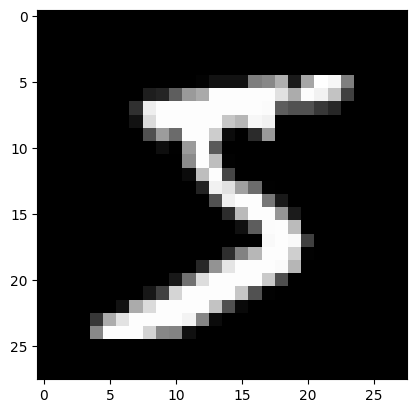

In [3]:
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print(label)

1


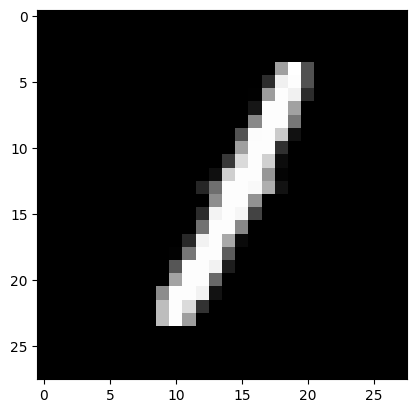

In [4]:
def view_data(index):
  image, label = dataset[index]
  plt.imshow(image, cmap='gray')
  print(label)

view_data(9837)

In [5]:
import torchvision.transforms as transforms
dataset = MNIST(root='/content', transform=transforms.ToTensor(), train=True) # convert the image into Tensors

In [6]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label) #(color_channel, height, width)

torch.Size([1, 28, 28]) 5


In [7]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


[0, 10:15, 10:15]:

0: Selects the first image from the batch.

10:15: A slice for rows. This means rows 10 to 14 (inclusive of 10, exclusive of 15).

10:15: A slice for columns. This means columns 10 to 14 (inclusive of 10, exclusive of 15).

In [8]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [9]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size) # user for evaluation so no need to shuffle

In [10]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [30]:
import torch.nn.functional as F
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
      image, label = batch
      out = self(image)
      loss = F.cross_entropy(out, label)
      return loss

    def validation_step(self, batch):
      image, label = batch
      out = self(image)
      loss = F.cross_entropy(out, label)
      acc = accuracy(out, label)
      return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [12]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model.linear.weight.shape, model.linear.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [16]:
list(model.parameters()) # intial parameters

[Parameter containing:
 tensor([[-0.0088, -0.0304, -0.0263,  ..., -0.0227, -0.0073,  0.0043],
         [ 0.0164,  0.0229, -0.0157,  ...,  0.0342,  0.0082,  0.0112],
         [-0.0026,  0.0336, -0.0356,  ..., -0.0146,  0.0164,  0.0326],
         ...,
         [-0.0191,  0.0162, -0.0148,  ...,  0.0011,  0.0256, -0.0224],
         [-0.0186,  0.0289,  0.0173,  ...,  0.0353, -0.0128,  0.0235],
         [ 0.0160, -0.0063, -0.0348,  ...,  0.0305,  0.0278, -0.0111]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0142,  0.0341,  0.0249,  0.0210, -0.0263,  0.0060,  0.0338, -0.0176,
         -0.0093,  0.0202], requires_grad=True)]

In [23]:
import torch.nn.functional as F

for image, label in train_loader:
  output = model(image)
  break

print(output.shape) # (number of images in batch, their predictions)

# convert to probs

prob = F.softmax(output, dim=1) # apply along the row

preds, probs = torch.max(prob, dim=1)
print(probs, preds)

torch.Size([128, 10])
tensor([4, 9, 4, 2, 1, 5, 3, 6, 0, 4, 1, 6, 2, 8, 5, 4, 4, 6, 3, 4, 0, 2, 1, 4,
        4, 0, 2, 4, 8, 1, 4, 3, 0, 2, 2, 3, 2, 1, 9, 0, 2, 4, 8, 4, 3, 3, 2, 2,
        2, 1, 5, 4, 4, 0, 3, 1, 1, 0, 5, 2, 3, 2, 2, 2, 4, 1, 1, 1, 3, 4, 6, 0,
        2, 0, 7, 2, 4, 5, 4, 9, 4, 2, 6, 4, 4, 2, 2, 1, 2, 2, 4, 0, 2, 2, 0, 2,
        4, 2, 4, 0, 0, 9, 2, 0, 2, 2, 3, 1, 4, 4, 3, 0, 4, 8, 1, 1, 9, 4, 8, 5,
        8, 4, 4, 5, 4, 4, 2, 8]) tensor([0.1349, 0.1181, 0.1216, 0.1308, 0.1095, 0.1325, 0.1144, 0.1287, 0.1380,
        0.1239, 0.1195, 0.1199, 0.1164, 0.1346, 0.1206, 0.1213, 0.1206, 0.1257,
        0.1186, 0.1192, 0.1186, 0.1415, 0.1087, 0.1419, 0.1415, 0.1125, 0.1357,
        0.1266, 0.1586, 0.1275, 0.1362, 0.1229, 0.1175, 0.1176, 0.1206, 0.1182,
        0.1183, 0.1093, 0.1393, 0.1241, 0.1476, 0.1158, 0.1165, 0.1326, 0.1294,
        0.1211, 0.1423, 0.1547, 0.1211, 0.1330, 0.1142, 0.1280, 0.1283, 0.1220,
        0.1223, 0.1147, 0.1213, 0.1418, 0.1250, 0.1288, 0.1511, 0

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

accuracy(output, label)

tensor(0.2109)

In [27]:
print(F.cross_entropy(output, label))

tensor(2.2762, grad_fn=<NllLossBackward0>)


In [31]:
def fit(epochs, lr, model, train_loader, val_loarder, opt=torch.optim.SGD):
  optimizer = opt(model.parameters(), lr)
  history = []

  for epoch in range(epochs):

    for batch in train_loader:
      output = model(image)
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    res = evaluate(model, val_loader)
    model.epoch_end(epoch, res)
    history.append(res)

  return history


result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.2840001583099365, 'val_acc': 0.1389438360929489}

In [32]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9298, val_acc: 0.6494
Epoch [1], val_loss: 1.6669, val_acc: 0.7316
Epoch [2], val_loss: 1.4696, val_acc: 0.7598
Epoch [3], val_loss: 1.3200, val_acc: 0.7832
Epoch [4], val_loss: 1.2047, val_acc: 0.7959


In [33]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1140, val_acc: 0.8074
Epoch [1], val_loss: 1.0410, val_acc: 0.8153
Epoch [2], val_loss: 0.9812, val_acc: 0.8213
Epoch [3], val_loss: 0.9314, val_acc: 0.8263
Epoch [4], val_loss: 0.8892, val_acc: 0.8319


In [34]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8531, val_acc: 0.8360
Epoch [1], val_loss: 0.8217, val_acc: 0.8393
Epoch [2], val_loss: 0.7942, val_acc: 0.8424
Epoch [3], val_loss: 0.7699, val_acc: 0.8442
Epoch [4], val_loss: 0.7483, val_acc: 0.8465


In [35]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7289, val_acc: 0.8484
Epoch [1], val_loss: 0.7114, val_acc: 0.8500
Epoch [2], val_loss: 0.6956, val_acc: 0.8523
Epoch [3], val_loss: 0.6811, val_acc: 0.8537
Epoch [4], val_loss: 0.6678, val_acc: 0.8552


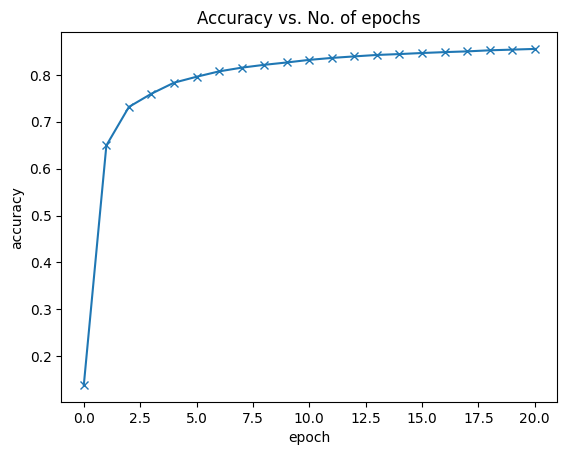

In [36]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [37]:
test_data = MNIST(root='/content', train=False, transform = transforms.ToTensor())

def predict_image(img, model):
    xb = img.unsqueeze(0) # img.unsqueeze simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


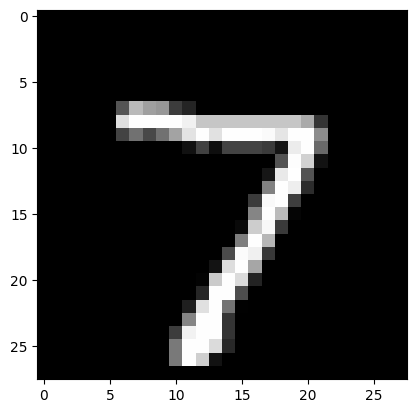

In [38]:
img, label = test_data[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [40]:
test_loader = DataLoader(test_data, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6393433809280396, 'val_acc': 0.86083984375}

In [41]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [42]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))

<ipython-input-42-c9094a019e06>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('mnist-logistic.pth'))


<All keys matched successfully>

In [43]:
evaluate(model2, test_loader)

{'val_loss': 0.6393433809280396, 'val_acc': 0.86083984375}